<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;">
<strong><centre>Preprocessing</centre></strong></h1>


#### Import Libraries and Load Data

In [9]:
import os
import random

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Load Dataset:

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/valid'

#classes to be used
classes = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
           'olympic wrestling', 'rugby', 'canoe slamon', 'roller derby', 'high jump',
           'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
           'rings', 'swimming', 'uneven bars', 'figure skating pairs']

Num GPUs Available:  0


#### Display Sample Images:

In [11]:
def show_random_images_with_labels(main_folder, num_images=5):
    subfolders = [os.path.join(main_folder, f) for f in os.listdir(main_folder) if
                  os.path.isdir(os.path.join(main_folder, f))]
    random.shuffle(subfolders)

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 5))
    for i, subfolder in enumerate(subfolders[:num_images]):
        image_paths = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if
                       f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(image_paths)
        image_path = image_paths[0]

        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            os.path.basename(image_path) + f" ({os.path.basename(subfolder)})",
            fontsize=10
        )

    plt.tight_layout()
    plt.show()

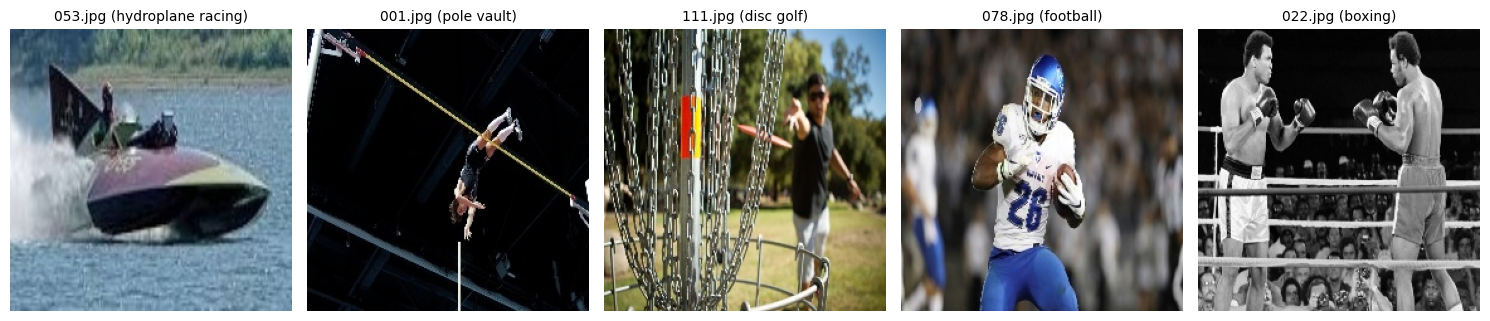

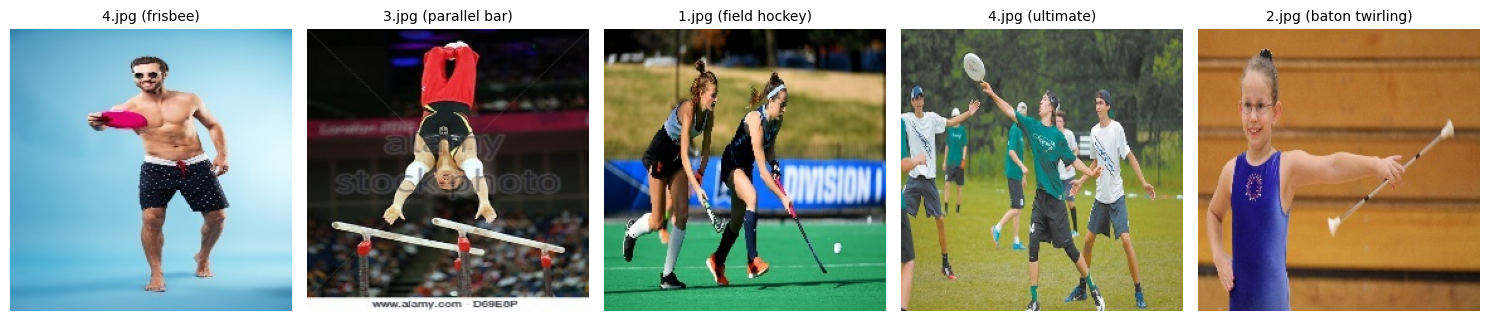

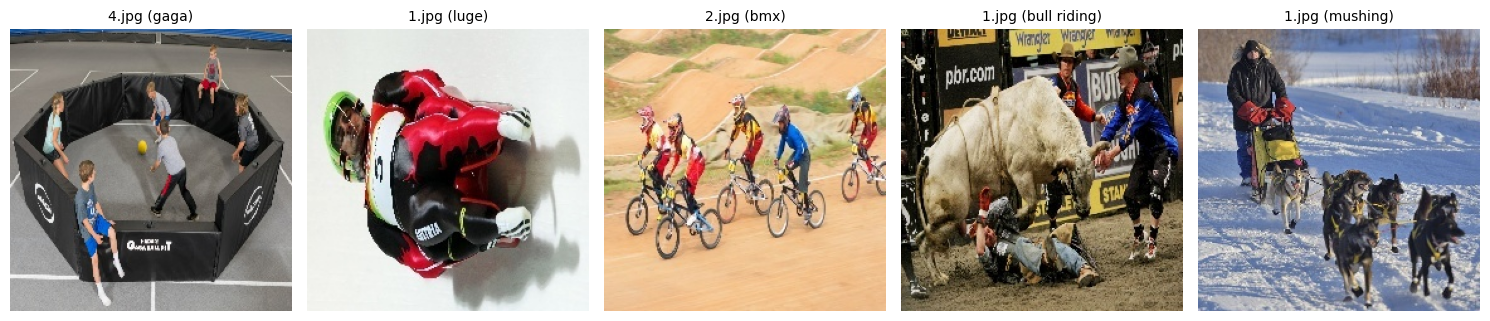

In [12]:
show_random_images_with_labels(train_dir, 5)
show_random_images_with_labels(test_dir, 5)
show_random_images_with_labels(val_dir, 5)

In [13]:
import math

def load_data(data_dir, batch_size, img_size):
    datagen = ImageDataGenerator()
    data_flow = datagen.flow_from_directory(
        data_dir,
        class_mode="categorical",
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        classes=classes
    )
    dataset = tf.data.Dataset.from_generator(
        lambda: data_flow,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, *img_size, 3], [None, len(classes)])
    )
    return dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE), math.ceil(data_flow.samples / batch_size)

#dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE): Prefetches the data to improve performance by overlapping the data preprocessing and model execution.
#buffer_size=tf.data.experimental.AUTOTUNE: TensorFlow automatically tunes the buffer size.
#math.ceil(data_flow.samples / batch_size): Calculates the number of steps per epoch by dividing the total number of samples by the batch size and taking the ceiling.

img_size = (150, 150)

#### Data Distribution:

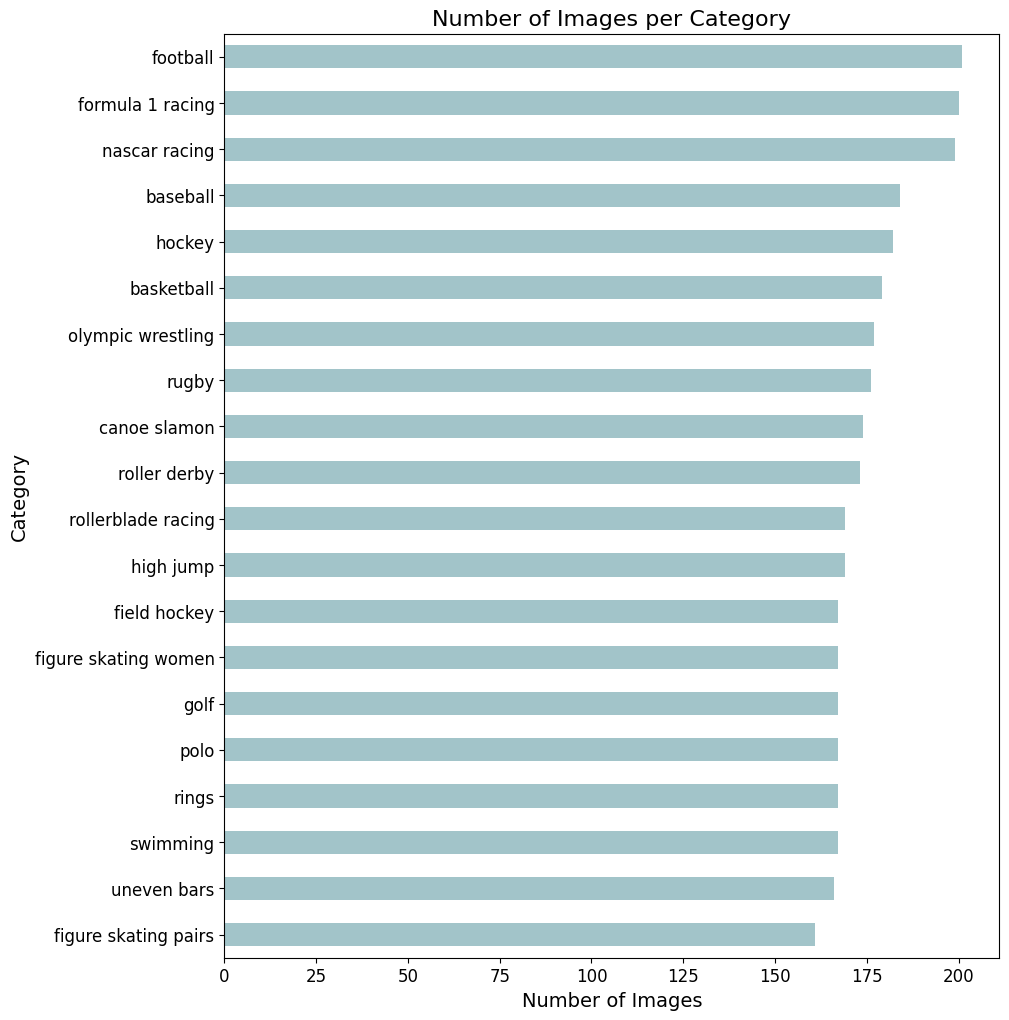

In [14]:

import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the data directories and categories (classes)
data_dirs = ['data/train', 'data/valid', 'data/test']
categories = ['football', 'formula 1 racing', 'nascar racing', 'baseball', 'hockey', 'basketball',
              'olympic wrestling', 'rugby', 'canoe slamon', 'roller derby', 'high jump',
              'rollerblade racing', 'field hockey', 'figure skating women', 'golf', 'polo',
              'rings', 'swimming', 'uneven bars', 'figure skating pairs']

# Initialize a dictionary to count images per category
category_counts = {category: 0 for category in categories}

# Count the number of images in each category across all directories
for data_dir in data_dirs:
    for category in categories:
        category_path = os.path.join(data_dir, category)
        if os.path.exists(category_path):
            category_counts[category] += len(os.listdir(category_path))

# Convert the dictionary to a pandas Series and sort
category_counts = pd.Series(category_counts).sort_values(ascending=False)

# Plot the number of images per category with horizontal bars
plt.figure(figsize=(10, 12))
category_counts.plot(kind='barh', color='#a2c4c9')
plt.title('Number of Images per Category', fontsize=16)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Optional: Invert the y-axis if you want the largest category on top
plt.show()



#### Split the dataset into training and validation datasets

---

In [15]:
train_dataset, steps_per_epoch = load_data(train_dir, batch_size=64, img_size=img_size)
val_dataset, validation_steps = load_data(val_dir, batch_size=64, img_size=img_size)
test_dataset, test_steps = load_data(test_dir, batch_size=64, img_size=img_size)

Found 3311 images belonging to 20 classes.
Found 100 images belonging to 20 classes.
Found 100 images belonging to 20 classes.


<h1 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;">
<strong><centre>Model Training</centre></strong></h1>

### Base Model

---

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Número de classes
num_classes = len(classes)

model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(units=num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 175232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │     3,504,660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,505,556 (13.37 MB)

 Trainable params: 3,505,556 (13.37 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.0835 - loss: 518.3890 - val_accuracy: 0.2500 - val_loss: 71.8812
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.3075 - loss: 69.9333 - val_accuracy: 0.4700 - val_loss: 31.9753
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.4656 - loss: 37.8803 - val_accuracy: 0.4000 - val_loss: 43.4206
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.5986 - loss: 23.8866 - val_accuracy: 0.4800 - val_loss: 32.4369
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.7258 - loss: 14.8238 - val_accuracy: 0.5400 - val_loss: 32.2267
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.8020 - loss: 8.8384 - val_accuracy: 0.4700 - val_loss: 38.8698
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.8191 - loss: 7.7155 - val_accuracy: 0.5400 - val_loss: 31.8630
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8799 - loss: 5.3964 -

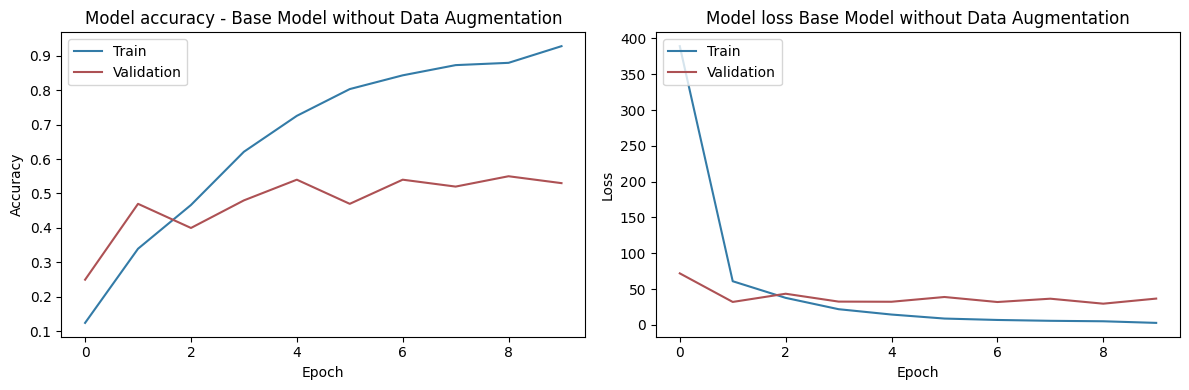

In [21]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], color='#337ba7')
    ax1.plot(history.history['val_accuracy'], color='#ad5154')
    ax1.set_title('Model accuracy - Base Model without Data Augmentation')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], color='#337ba7')
    ax2.plot(history.history['val_loss'], color='#ad5154')
    ax2.set_title('Model loss Base Model without Data Augmentation')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [20]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=test_steps)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")
model.save('final_model_base_model.keras')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5965 - loss: 29.4405
Test accuracy: 59.00%
Test loss: 29.9454
